# Data Augmentation
### (and further EDA)

As demonstrated in the EDA notebook of this project, there are marked differences between wheat images across domains. The original challenge pre-divided the image dataset into train, test, and validation folders, with *completely distinct* sets of domains in each folder. Even if the images were apparently very similar across domains, this would not be a wise project design. But we've also demonstrated that there are clear differences between images from varying domains. To correct for this, we will combine the pre-divided train, test, and validation folders, augment the full set of data to account for any class imbalances, and then re-split into testing, training, and validation folders with even (or, as even as possible) representation across image sets. 

In [1]:
import pandas as pd
import pathlib
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

In [2]:
#import utilities
import sys
sys.path.append('src/')
import utils as utils

In [62]:
import albumentations as A
import cv2

In [4]:
test = pd.read_csv('gwhd_2021/competition_test.csv')
train = pd.read_csv('gwhd_2021/competition_train.csv')
val = pd.read_csv('gwhd_2021/competition_val.csv')

In [5]:
full = pd.concat([train, test, val])

We'll save this full dataframe to a csv file:

In [6]:
# full.to_csv('transformed_data/train_test_val_concat.csv')

Now, we'll need to perform the same basic transformations to this new dataframe, as we did to the original training dataset dataframe (like reformatting of bounding box coordinates, etc). We'll also want to merge the metadata information so that we can address class imbalances when performing data augmentation and when performing the new splits. 

In [7]:
metadata = pd.read_csv('gwhd_2021/metadata_dataset.csv', sep=';')

In [8]:
# Update metadata['name'] to metadata['domain'] to match full column name
metadata.rename(columns = {"name": "domain"}, inplace=True)

In [9]:
df = full.merge(metadata, on='domain')

In [10]:
df.head()

,image_name,BoxesString,domain,country,location,development_stage
0,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,99 692 160 764;641 27 697 115;935 978 1012 102...,Arvalis_1,France,Gréoux,Post-flowering
1,a2a15938845d9812de03bd44799c4b1bf856a8ad11752e...,230 143 321 222;928 929 1015 1004;485 557 604 ...,Arvalis_1,France,Gréoux,Post-flowering
2,401f89a2bb6ab63e3f406bd59b9cadccfe953230feb6cd...,440 239 544 288;333 538 429 594;913 171 963 20...,Arvalis_1,France,Gréoux,Post-flowering
3,0a3937653483c36dfb4d957b6f82ae96dbdc7ba36cc3d8...,112 274 188 303;892 812 958 847;0 889 67 928;1...,Arvalis_1,France,Gréoux,Post-flowering
4,be1652110a44acd24b42784356e965ce84a04893c3f1bb...,810 204 863 314;360 231 425 408;452 348 510 47...,Arvalis_1,France,Gréoux,Post-flowering


Change image name to read `.jpg` instead of `.png`:

In [11]:
for i, row in df.iterrows():
    row['image_name'] = (row.image_name.split('.')[0]+'.jpg')

Check for duplicated images:

In [12]:
df.image_name[df.image_name.duplicated()]

2070    d88963636d49127bda0597ef73f1703e92d6f111caefc4...
2079    1961bcf453d5b2206c428c1c14fe55d1f26f3c655db0a2...
3948    da9846512ff19b8cd7278c8c973f75d36de8c4eb4e593b...
Name: image_name, dtype: object

In [13]:
df[df.image_name == df.iloc[2070, 0]]

,image_name,BoxesString,domain,country,location,development_stage
1986,d88963636d49127bda0597ef73f1703e92d6f111caefc4...,994 8 1024 64;864 0 1012 92;642 18 772 102;616...,Arvalis_10,France,Mons,Filling
2070,d88963636d49127bda0597ef73f1703e92d6f111caefc4...,312 994 364 1024;177 756 296 869;88 118 147 17...,Arvalis_12,France,Gréoux,Filling


In [14]:
df['image_name'].iloc[2070]

'd88963636d49127bda0597ef73f1703e92d6f111caefc44902d5932b8cd3fa94.jpg'

In [15]:
df[df.image_name == df.iloc[2079, 0]]

,image_name,BoxesString,domain,country,location,development_stage
1999,1961bcf453d5b2206c428c1c14fe55d1f26f3c655db0a2...,264 164 370 296;388 196 464 330;466 328 698 44...,Arvalis_10,France,Mons,Filling
2079,1961bcf453d5b2206c428c1c14fe55d1f26f3c655db0a2...,3 944 58 985;876 506 919 555;770 859 834 903;9...,Arvalis_12,France,Gréoux,Filling


In [16]:
df[df.image_name == df.iloc[3948, 0]]

,image_name,BoxesString,domain,country,location,development_stage
3821,da9846512ff19b8cd7278c8c973f75d36de8c4eb4e593b...,950 39 986 165;725 2 776 226;660 31 720 92;797...,CIMMYT_1,Mexico,Ciudad Obregon,Post-flowering
3948,da9846512ff19b8cd7278c8c973f75d36de8c4eb4e593b...,733 0 837 49;688 96 998 196;792 433 843 461;73...,CIMMYT_3,Mexico,Ciudad Obregon,Post-flowering


After confirming that each of these image names only appears once in the image dataset, we can delete the duplicated csv row for each.

In [17]:
df = df.drop([2070, 2079, 3948])

In [18]:
# confirm no more duplicate image entries occur
df.image_name[df.image_name.duplicated()]

Series([], Name: image_name, dtype: object)

In [19]:
df.reset_index(inplace=True, drop=True)

In [20]:
df2 = df.copy()

In [21]:
for i, row in df2.iterrows():
    row['BoxesString'] = list(row['BoxesString'].split(';'))
    
df2 = df2.explode('BoxesString')
    
for i, row in df2.iterrows():
    row['BoxesString'] = list(row['BoxesString'].split(' '))

In [22]:
df2.BoxesString = df2.BoxesString.apply(lambda y: list('0 0 0 0'.split(" ")) if len(y)==1 else y)

In [23]:
bbox_xmin = []
bbox_ymin = []
bbox_width = []
bbox_height = []

In [24]:
df_lst = list(df2.BoxesString)

In [25]:
for bbox_lst in df_lst:
    bbox_xmin.append(bbox_lst[0])
    bbox_ymin.append(bbox_lst[1])
    bbox_width.append(bbox_lst[2])
    bbox_height.append(bbox_lst[3])

In [26]:
df2['bbox_xmin'] = bbox_xmin
df2['bbox_ymin'] = bbox_ymin
df2['bbox_xmax'] = bbox_width
df2['bbox_ymax'] = bbox_height

In [27]:
df2.reset_index(inplace=True, drop=True)

In [28]:
df2.head()

,image_name,BoxesString,domain,country,location,development_stage,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax
0,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[99, 692, 160, 764]",Arvalis_1,France,Gréoux,Post-flowering,99,692,160,764
1,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[641, 27, 697, 115]",Arvalis_1,France,Gréoux,Post-flowering,641,27,697,115
2,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[935, 978, 1012, 1020]",Arvalis_1,France,Gréoux,Post-flowering,935,978,1012,1020
3,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[377, 834, 463, 890]",Arvalis_1,France,Gréoux,Post-flowering,377,834,463,890
4,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[654, 797, 696, 837]",Arvalis_1,France,Gréoux,Post-flowering,654,797,696,837


In [29]:
df2.dtypes

image_name           object
BoxesString          object
domain               object
country              object
location             object
development_stage    object
bbox_xmin            object
bbox_ymin            object
bbox_xmax            object
bbox_ymax            object
dtype: object

In [30]:
df2 = df2.astype({'bbox_xmin': 'float', 'bbox_ymin': 'float', 'bbox_xmax': 'float', 'bbox_ymax': 'float'})

In [31]:
df2.dtypes

image_name            object
BoxesString           object
domain                object
country               object
location              object
development_stage     object
bbox_xmin            float64
bbox_ymin            float64
bbox_xmax            float64
bbox_ymax            float64
dtype: object

In [32]:
#create data directory path and count images
data_dir = pathlib.Path('gwhd_2021/images')

In [33]:
images = list(data_dir.glob('*.jpg'))

In [34]:
# Take dataframe and image_name for which we want bounding boxes and return list of x, y, w, h

def get_all_bboxes(df, image_name):
    image_bounding_boxes = df[df.image_name == image_name]
  
    bounding_boxes = []
    for _, row in image_bounding_boxes.iterrows():
        bounding_boxes.append((row.bbox_xmin, row.bbox_ymin, row.bbox_xmax-row.bbox_xmin, row.bbox_ymax-row.bbox_ymin))
    
    return bounding_boxes

In [35]:
# Plot examples of images with their bounding boxes

def plot_image_examples(dataframe, rows = 3, cols = 3, title = 'Image examples', size = (10, 10)):
    fig, axs = plt.subplots(rows, cols, figsize=size)
    for row in range(rows):
        for col in range(cols):
            idx = np.random.randint(len(dataframe), size = 1)[0]
            img_id = dataframe.iloc[idx].image_name
      
            img = Image.open(data_dir / img_id)
            axs[row, col].imshow(img)
      
            bboxes = get_all_bboxes(dataframe, img_id)
      
            for bbox in bboxes:
                rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
                axs[row, col].add_patch(rect)
        
                axs[row, col].axis('off')    
    plt.suptitle(title, fontsize = 18)

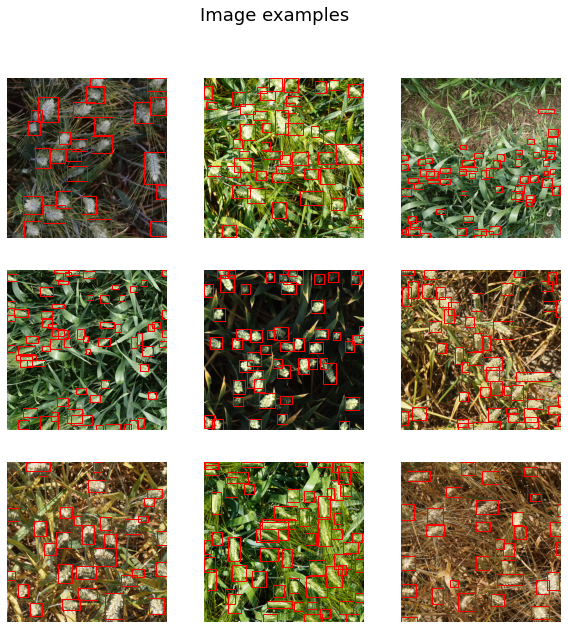

In [36]:
plot_image_examples(df2)

In [37]:
# Plot single image with all bounding boxes
def plot_image_with_bboxes(dataframe, img_name, title = 'Image examples', size = (5, 5)):
    fig, ax = plt.subplots(figsize=size)
    img = Image.open(data_dir / img_name)
    ax.imshow(img)
      
    bboxes = get_all_bboxes(dataframe, img_name)
      
    for bbox in bboxes:
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        
        ax.axis('off')    
    plt.suptitle(title, fontsize = 16)

In [38]:
#domain_mean = df2.groupby('domain')['image_name'].count().mean()

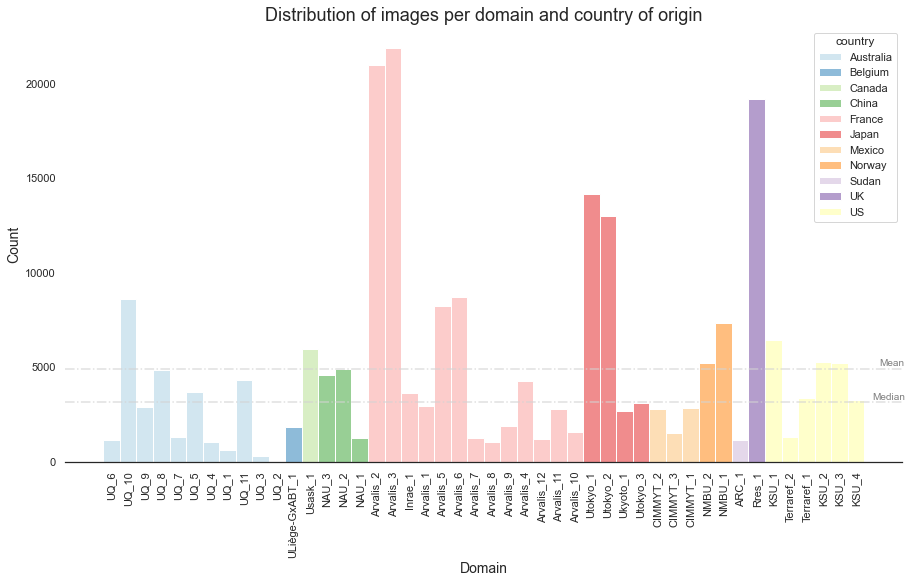

In [39]:
sns.set(rc={'figure.figsize':(15, 8)})
sns.set_style("white")
ax = sns.histplot(data=df2.sort_values(by='country'), x='domain', hue='country', palette='Paired')
plt.xticks(rotation=90)
#for container in ax.containers:
    #ax.bar_label(container, fontsize=10)
plt.xlabel('Domain', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.title('Distribution of images per domain and country of origin', fontsize=18)
plt.axhline(df2.groupby('domain')['image_name'].count().mean(), ls='-.', color='lightgray', 
            label='Mean', alpha=0.7)
plt.axhline(df2.groupby('domain')['image_name'].count().median(), ls='-.', color='lightgray', 
            label='Median', alpha=0.7)
ax.text(46.39, 5100, "Mean", fontsize=10, color='gray')
ax.text(46, 3300, "Median", fontsize=10, color='gray')
sns.despine(left=True)
plt.show()

In [40]:
#country_mean = df2.groupby('country')['image_name'].count().mean()

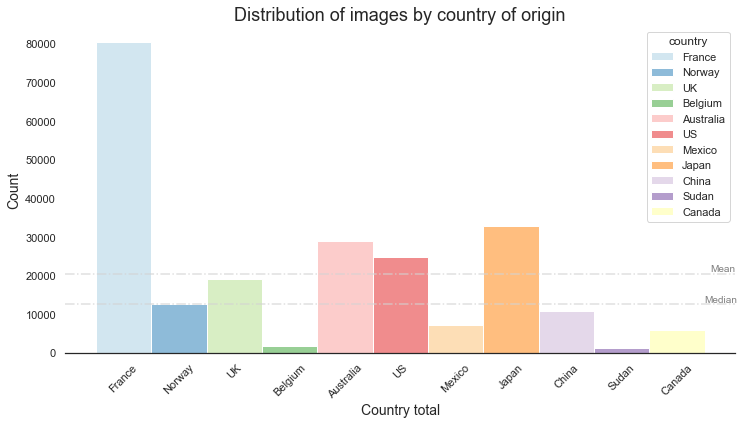

In [41]:
sns.set(rc={'figure.figsize':(12, 6)})
sns.set_style("white")
ax = sns.histplot(data=df2, x='country', hue='country', palette = 'Paired')
plt.xticks(rotation=45)
plt.xlabel('Country total', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.title('Distribution of images by country of origin', fontsize=18)
plt.axhline(df2.groupby('country')['image_name'].count().mean(), ls='-.', color='lightgray', 
            label='Mean', alpha=0.7)
plt.axhline(df2.groupby('country')['image_name'].count().median(), ls='-.', color='lightgray', 
            label='Median', alpha=0.7)
ax.text(10.61, 21000, "Mean", fontsize=10, color='gray')
ax.text(10.5, 13000, "Median", fontsize=10, color='gray')
sns.despine(left=True)
plt.show()

In [42]:
df2[df2['development_stage'] == 'Post-Flowering'].count()

image_name           2672
BoxesString          2672
domain               2672
country              2672
location             2672
development_stage    2672
bbox_xmin            2672
bbox_ymin            2672
bbox_xmax            2672
bbox_ymax            2672
dtype: int64

In [43]:
df2[df2['development_stage'] == 'Post-flowering'].count()

image_name           33033
BoxesString          33033
domain               33033
country              33033
location             33033
development_stage    33033
bbox_xmin            33033
bbox_ymin            33033
bbox_xmax            33033
bbox_ymax            33033
dtype: int64

In [44]:
df3 = df2.copy()

In [45]:
df3.loc[(df3.development_stage == 'Post-Flowering'),'development_stage'] = 'Post-flowering'

In [46]:
counter_F = 0
counter_f = 0
for i, row in df3.iterrows():
    if row['development_stage'] == 'Post-Flowering':
        counter_F += 1
    if row['development_stage'] == 'Post-flowering':
        counter_f +=1

In [47]:
print(counter_F)
print(counter_f)

0
35705


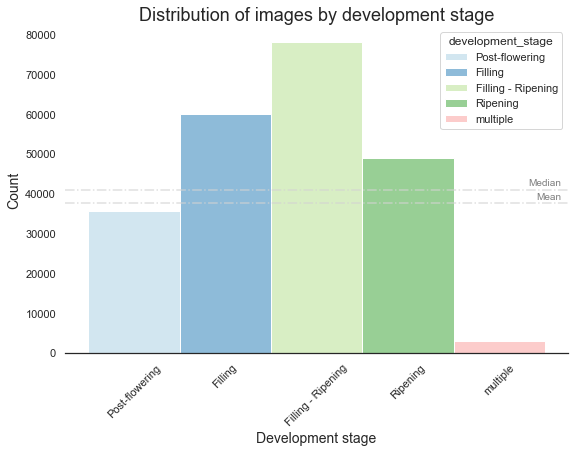

In [48]:
sns.set(rc={'figure.figsize':(9, 6)})
sns.set_style("white")
ax = sns.histplot(data=df3, x='development_stage', hue='development_stage', palette = 'Paired')
plt.xticks(rotation=45)
plt.xlabel('Development stage', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.title('Distribution of images by development stage', fontsize=18)
plt.axhline(df2.groupby('development_stage')['image_name'].count().mean(), ls='-.', color='lightgray', 
            label='Mean', alpha=0.7)
plt.axhline(df2.groupby('development_stage')['image_name'].count().median(), ls='-.', color='lightgray', 
            label='Median', alpha=0.7)
ax.text(4.41, 38500, "Mean", fontsize=10, color='gray')
ax.text(4.32, 42000, "Median", fontsize=10, color='gray')
sns.despine(left=True)
plt.show()

There's relatively few images with development stage classified as `multiple`. Let's check out what these images look like.

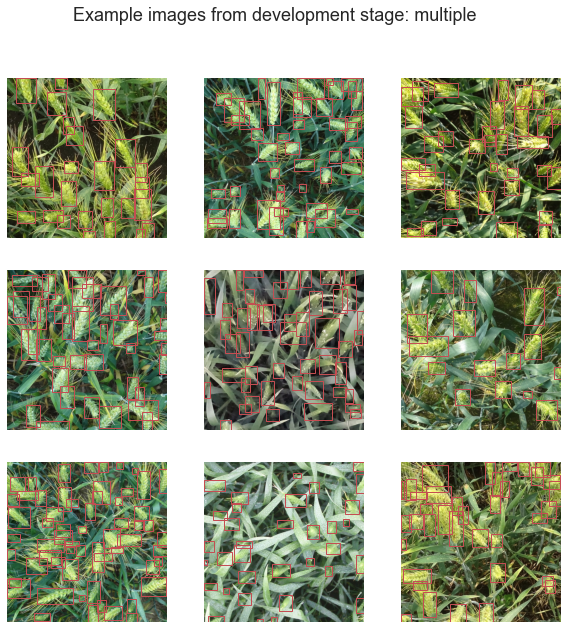

In [49]:
# Example images with large bounding box areas
multiple_dev_stage = df3[df3['development_stage'] == 'multiple'].image_name
plot_image_examples(df3[df3.image_name.isin(multiple_dev_stage)], 
                    title='Example images from development stage: multiple')

I'm no expert in wheat head development stages, and it seems believable that these images were intentionally classified as being in `multiple` development stages, so I'll leave them as is. It doesn't seem urgently necessary to address the class imbalance of the `multiple` development stage, however. 

## Data Augmentation
Data augmentation is critical to this challenge, as the image dataset is rather small. Because we need to translate the bounding box labels to the augmented data, I've chose the Albumentations library, which allows for parallel bounding box augmentation.

See link here for [bounding box augmentation for object detection](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/)

Note to self: Albumentations library requires bounding boxes to be in `[xmin, ymin, xmax, ymax]` format (which the data already is). *IF I CHANGE AUGMENTATION METHOD:* Make sure to double-check required bounding box format, as it differs significantly between methods. 

We also will want to keep in mind that in order to train a classifier that is balanced in its accuracy for all classes we will want a balanced training set.

Also, it is beneficial to be able to control the magnitude of image augmentation, how much does the augmentation change the original image. If the original dataset is large, you could apply only the basic augmentations with probability around 10-30% and with a small magnitude of changes. If the dataset is small, you need to act more aggressively with augmentations to prevent overfitting of neural networks, so you usually need to increase the probability of applying each augmentation to 40-50% and increase the magnitude of changes the augmentation makes to the image.

Here is an example definition of an augmentation pipeline. This pipeline will first crop a random 512px x 512px part of the input image. Then with probability 30%, it will randomly change brightness and contrast of that crop. Finally, with probability 50%, it will horizontally flip the resulting image.


```
import albumentations as A

transform = A.Compose([
    A.RandomCrop(512, 512),
    A.RandomBrightnessContrast(p=0.3),
    A.HorizontalFlip(p=0.5),
])
```

A bug in the augmentation pipeline could easily go unnoticed. A buggy pipeline could silently corrupt input data. There won't be any exceptions and code failures, but the performance of trained neural networks will degrade because they received a garbage input during training. Augmentation libraries usually have large test suites that capture regressions during development. Also large user base helps to find unnoticed bugs and report them to developers.

In [50]:
df3.head()

,image_name,BoxesString,domain,country,location,development_stage,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax
0,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[99, 692, 160, 764]",Arvalis_1,France,Gréoux,Post-flowering,99.0,692.0,160.0,764.0
1,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[641, 27, 697, 115]",Arvalis_1,France,Gréoux,Post-flowering,641.0,27.0,697.0,115.0
2,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[935, 978, 1012, 1020]",Arvalis_1,France,Gréoux,Post-flowering,935.0,978.0,1012.0,1020.0
3,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[377, 834, 463, 890]",Arvalis_1,France,Gréoux,Post-flowering,377.0,834.0,463.0,890.0
4,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[654, 797, 696, 837]",Arvalis_1,France,Gréoux,Post-flowering,654.0,797.0,696.0,837.0


Currently, the `BoxesString` column contains lists of strings. This could pose a problem, so first I'll convert that column to a list of floats (in preparation for normalization to a range of 0-1 for the `albumentations` library coming up next).

In [51]:
df4 = df3.copy()

In [52]:
print(df4.iloc[0,1])

['99', '692', '160', '764']


In [55]:
for i, row in df4.iterrows():
    for i in range(0, 4):
        row[1][i] = float(row[1][i])

In [56]:
print(df4.iloc[0,1])

[99.0, 692.0, 160.0, 764.0]


**`albumentations` uses normalized values. To normalize values, divide coordinates for the x- and y-axis by the total width and total height (in pixels) of the image.** To normalize bounding box values to the range of 0-1, divide x and y coordinates by height and width of the image, respectively (in our case the images are 1024 pixels x 1024 pixels). 

[x_min, y_min, x_max, y_max]

In [59]:
for i, row in df4.iterrows():
    for i in range(0, 4):
        row[1][i] = row[1][i] / 1024

In [60]:
print(df4.iloc[0,1])

[0.0966796875, 0.67578125, 0.15625, 0.74609375]


In [61]:
df4.head()

,image_name,BoxesString,domain,country,location,development_stage,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax
0,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[0.0966796875, 0.67578125, 0.15625, 0.74609375]",Arvalis_1,France,Gréoux,Post-flowering,99.0,692.0,160.0,764.0
1,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[0.6259765625, 0.0263671875, 0.6806640625, 0.1...",Arvalis_1,France,Gréoux,Post-flowering,641.0,27.0,697.0,115.0
2,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[0.9130859375, 0.955078125, 0.98828125, 0.9960...",Arvalis_1,France,Gréoux,Post-flowering,935.0,978.0,1012.0,1020.0
3,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[0.3681640625, 0.814453125, 0.4521484375, 0.86...",Arvalis_1,France,Gréoux,Post-flowering,377.0,834.0,463.0,890.0
4,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[0.638671875, 0.7783203125, 0.6796875, 0.81738...",Arvalis_1,France,Gréoux,Post-flowering,654.0,797.0,696.0,837.0


Or use **`pascal voc`** bbox coordinate format? Try both?

In [64]:
df2.head()

,image_name,BoxesString,domain,country,location,development_stage,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax
0,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[0.0966796875, 0.67578125, 0.15625, 0.74609375]",Arvalis_1,France,Gréoux,Post-flowering,99.0,692.0,160.0,764.0
1,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[0.6259765625, 0.0263671875, 0.6806640625, 0.1...",Arvalis_1,France,Gréoux,Post-flowering,641.0,27.0,697.0,115.0
2,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[0.9130859375, 0.955078125, 0.98828125, 0.9960...",Arvalis_1,France,Gréoux,Post-flowering,935.0,978.0,1012.0,1020.0
3,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[0.3681640625, 0.814453125, 0.4521484375, 0.86...",Arvalis_1,France,Gréoux,Post-flowering,377.0,834.0,463.0,890.0
4,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[0.638671875, 0.7783203125, 0.6796875, 0.81738...",Arvalis_1,France,Gréoux,Post-flowering,654.0,797.0,696.0,837.0


### Bounding boxes augmentation
Just like with images and masks augmentation, the process of augmenting bounding boxes consists of 4 steps:
1. Import the required libraries.
2. Define an augmentation pipeline.
3. Read images and bounding boxes from the disk.
4. Pass an image and bounding boxes to the augmentation pipeline and receive augmented images and boxes.

**Not all transformations can augment bounding boxes: [See full list here](https://albumentations.ai/docs/getting_started/transforms_and_targets/)**

* All pixel-level transformations are fine.
* Only some spatial-level transformations work.

Here is an example of Compose that shows all available settings with `A.BboxParams`:

```
transform = A.Compose([
    A.RandomCrop(width=450, height=450),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
], bbox_params=A.BboxParams(format='coco', min_area=1024, min_visibility=0.1, label_fields=['class_labels']))
```

**`min_area`** and **`min_visibility`**
`min_area` and `min_visibility` parameters control what Albumentations should do to the augmented bounding boxes if their size has changed after augmentation. The size of bounding boxes could change if you apply spatial augmentations, for example, when you crop a part of an image or when you resize an image.

`min_area` is a value in pixels. If the area of a bounding box after augmentation becomes smaller than `min_area`, Albumentations will drop that box. So the returned list of augmented bounding boxes won't contain that bounding box.

`min_visibility` is a value between 0 and 1. If the ratio of the bounding box area after augmentation to `the area of the bounding box before augmentation` becomes smaller than `min_visibility`, Albumentations will drop that box. So if the augmentation process cuts the most of the bounding box, that box won't be present in the returned list of the augmented bounding boxes.

In [ ]:
#ax = sns.countplot(x='domain', data=df2)
#for container in ax.containers:
    #ax.bar_label(container, rotation = 90)
#plt.xticks(rotation=90)
#plt.xlabel('Domain')
#plt.ylabel('Count', fontsize = 16)
#plt.show()

In [ ]:
'''
FOR ADDRESSING CLASS IMBALANCES (example code)

from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', classes=[0,1,2,3,4], y=df.label)
print(f'Relative Weights: {weights}\n\n')

plt.bar(cat_names, weights)
plt.axhline(np.mean(weights), color='red', ls='--', label='Mean')
plt.axhline(np.median(weights), color='yellow', ls='--', label='Median')
plt.title('Computed Relative Weights')
plt.legend()
plt.show()

///

tuned_weights = weights.copy()
tuned_weights[0] = tuned_weights[0] * 0.6
tuned_weights[3] = tuned_weights[3] * 1.7

plt.bar(cat_names, tuned_weights)
plt.axhline(np.mean(weights), color='red', ls='--', label='Old Mean')
plt.axhline(np.median(weights), color='yellow', ls='--', label='Old Median')
plt.title('Tuned Relative Weights')
plt.legend()
plt.show()

///

weighted_dist = tuned_weights * df.loc[:,'label'].value_counts(sort=False)

plt.bar(cat_names, weighted_dist)
plt.axhline(df.loc[:,'label'].value_counts().mean(), color='red', ls='--', label='Old Mean')
plt.axhline(df.loc[:,'label'].value_counts().median(), color='yellow', ls='--', label='Old Median')
plt.axhline(np.mean(weighted_dist), color='blue', ls='--', label='NEW Mean')
plt.axhline(np.median(weighted_dist), color='green', ls='--', label='NEW Median')
plt.title('Weighted Data Distribution')
plt.legend()
plt.show()
'''